# Project: Banff Traffic Management

**Group Name:** Mobility Innovators

**Team Members & Roles:**
* **Aquiles Escarra:** Project Manager
* **Inderjeet Singh:** Lead Data Scientist
* **Aditya Mehta:** Project Coordinator
* **Yungvir Singh:** Scrum Master

---

## Executive Summary: Traffic Volume EDA & Preprocessing

**Objective:**
This notebook focuses on the analysis and preparation of **Traffic Volume** data collected from vehicle sensors at key entry and exit points in Banff (e.g., East/West Entrances, Mountain Ave). Traffic flow is a critical leading indicator for parking demand.

**Methodology:**
1.  **Data Ingestion:** We import traffic count data from multiple sensor locations to construct a complete picture of vehicle movement in the town.
2.  **Temporal Alignment:** We standardize timestamps to ensure traffic data can eventually be synchronized with hourly parking transactions.
3.  **Flow Analysis:** We analyze **Inflow vs. Outflow** volume to estimate the net number of vehicles remaining in the town center at any given hour.
4.  **Pattern Recognition:** We visualize peak traffic windows to identify congestion times that likely precede parking saturation.

**Output:**
The processed traffic dataset from this notebook will serve as a primary predictor variable in the final Machine Learning model, allowing us to correlate "vehicles entering the town" with "parking spots filled."


## Importing Required Libraries & Loading the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1: Loading and Overview of the Dataset

**Load the four cleaned traffic datasets**
In this section, we import the four CSV files containing hourly vehicle counts for Banff’s main arteries.
Each file corresponds to a specific traffic corridor with two directions (Northbound and Southbound).

In [ ]:
# Load traffic volume datasets
df_1 = pd.read_csv('bridge_volumes_cleaned.csv')
df_2 = pd.read_csv('east_volume_cleaned.csv')
df_3 = pd.read_csv('mountain_ave_volumes_cleaned.csv')
df_4 = pd.read_csv('west_volume_cleaned.csv')

#Setting up notebook so that all columns are displayed
pd.set_option('display.max_columns', None)

#2: Data Cleaning and Preparation

**Inspect the structure of each dataset**
Before merging, it’s important to check that all four datasets have consistent column names, data types,
and formats (especially the datetime column).
We print .info() and a few sample rows from each DataFrame to compare their schemas.

In [ ]:
for i, df in enumerate([df_1, df_2, df_3, df_4], start=1):
    print(f"\n -> Estructure df_{i}:")
    print(df.info())
    print(df.head(3))


 -> Estructure df_1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29232 entries, 0 to 29231
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       29232 non-null  int64 
 1   month_num  29232 non-null  int64 
 2   month      29232 non-null  object
 3   day        29232 non-null  int64 
 4   date       29232 non-null  object
 5   hour       29232 non-null  int64 
 6   volume     29232 non-null  int64 
 7   direction  29232 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.8+ MB
None
   year  month_num   month  day        date  hour  volume   direction
0  2024          1  Jan-24    1  2024-01-01     1     122  Southbound
1  2024          1  Jan-24    1  2024-01-01     2      65  Southbound
2  2024          1  Jan-24    1  2024-01-01     3      52  Southbound

 -> Estructure df_2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29232 entries, 0 to 29231
Data columns (total 8 columns):
 #   Column    

**Standardize column names** All four datasets share a similar structure, but we will standardize column names and formats to ensure they are identical before merging.
Each DataFrame will receive an additional column named artery to identify its source (Bridge, East, Mountain Ave, or West).
We will also ensure the volume column is numeric and replace missing values where necessary.

In [ ]:
# Standardize column names (already consistent, only add artery label)
for df, name in zip(
    [df_1, df_2, df_3, df_4],
    ['Bridge', 'East Entrance', 'Mountain Ave', 'West Entrance']
):
    df['artery'] = name
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce')  # Ensure numeric type

# Quick verification
for i, df in enumerate([df_1, df_2, df_3, df_4], start=1):
    print(f" df_{i} standardized columns: {df.columns.tolist()}")


 df_1 standardized columns: ['year', 'month_num', 'month', 'day', 'date', 'hour', 'volume', 'direction', 'artery']
 df_2 standardized columns: ['year', 'month_num', 'month', 'day', 'date', 'hour', 'volume', 'direction', 'artery']
 df_3 standardized columns: ['year', 'month_num', 'month', 'day', 'date', 'hour', 'volume', 'direction', 'artery']
 df_4 standardized columns: ['year', 'month_num', 'month', 'day', 'date', 'hour', 'volume', 'direction', 'artery']


**Handle Missing and Inconsistent Values** We identify any missing values (especially in the volume column) and fill or remove them as needed.
Since traffic volumes cannot be negative or null, we replace missing values with 0 (if minimal) or with interpolated values (if in a continuous time series).

In [ ]:
# Check missing values
for i, df in enumerate([df_1, df_2, df_3, df_4], start=1):
    print(f"\nMissing values in df_{i}:")
    print(df.isna().sum())


Missing values in df_1:
year         0
month_num    0
month        0
day          0
date         0
hour         0
volume       0
direction    0
artery       0
dtype: int64

Missing values in df_2:
year         0
month_num    0
month        0
day          0
date         0
hour         0
volume       0
direction    0
artery       0
dtype: int64

Missing values in df_3:
year           0
month_num      0
month          0
day            0
date           0
hour           0
volume       387
direction      0
artery         0
dtype: int64

Missing values in df_4:
year         0
month_num    0
month        0
day          0
date         0
hour         0
volume       0
direction    0
artery       0
dtype: int64


**Analyze the structure of missing traffic data (Mountain Ave)**
Before deciding how to handle missing values, we must understand their pattern.
Missing data in time series may occur sporadically (e.g., a few hours) or in long continuous blocks (e.g., sensor offline for days).

In [ ]:
# Check how many values are missing in the 'volume' column
missing = df_3['volume'].isna()
print("Total missing values:", missing.sum())

# Create a list to store the length of each consecutive missing block
block_lengths = []
count = 0

# Loop through each value in the missing mask
for value in missing:
    if value:              # If this value is missing
        count += 1         # Increase the counter for the current block
    else:
        if count > 0:      # If a missing block just ended
            block_lengths.append(count)  # Save its length
            count = 0      # Reset the counter

# If the last block ends at the end of the dataset, store it too
if count > 0:
    block_lengths.append(count)

# Display summary
print("\nNumber of missing blocks:", len(block_lengths))
print("Lengths of each block (in hours):", block_lengths)
print("Longest missing block:", max(block_lengths) if block_lengths else 0)


Total missing values: 387

Number of missing blocks: 2
Lengths of each block (in hours): [386, 1]
Longest missing block: 386


The analysis revealed 387 missing records in the Mountain Ave dataset.
Almost all belong to a continuous block of 386 hours (~16 days), which clearly indicates a sensor outage.
In this case, interpolation would not be appropriate because it would artificially generate data for a long period with no real readings.

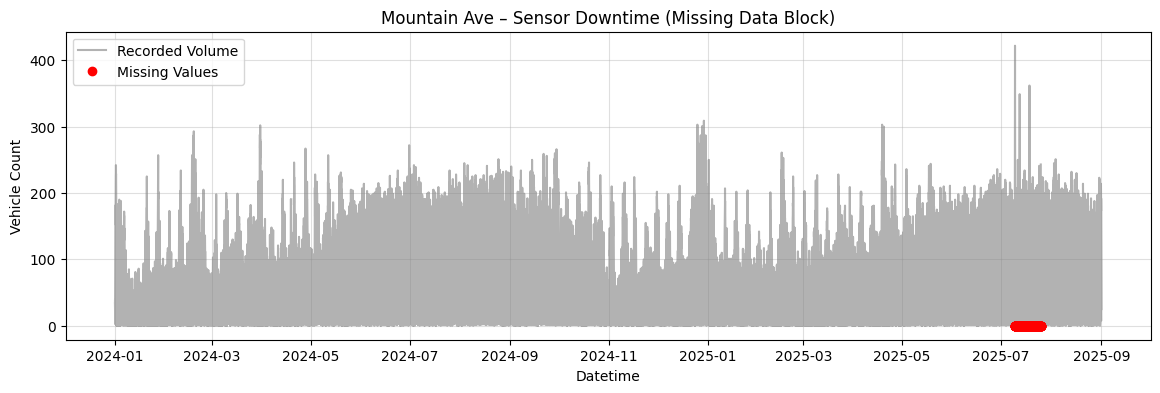

In [ ]:
# Ensure datetime column exists for plotting
df_3['datetime'] = pd.to_datetime(
    dict(year=df_3['year'], month=df_3['month_num'], day=df_3['day'], hour=df_3['hour']),
    errors='coerce'
)

# Visualize missing segment
plt.figure(figsize=(14,4))

plt.plot(df_3['datetime'], df_3['volume'], color='gray', alpha=0.6, label='Recorded Volume')

plt.plot(df_3.loc[df_3['volume'].isna(), 'datetime'],
         [0]*df_3['volume'].isna().sum(),
         'ro', label='Missing Values') # missing values

plt.title("Mountain Ave – Sensor Downtime (Missing Data Block)")
plt.xlabel("Datetime")
plt.ylabel("Vehicle Count")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

**Remove the long missing data block from Mountain Ave**
The analysis confirmed a continuous 16-day period with no valid traffic readings.
Because this gap represents a complete sensor outage rather than small noise,
we remove all rows with missing volume values from the Mountain Ave dataset.
This ensures the final dataset only includes actual observed traffic data.

This approach preserves the integrity of observed data without fabricating values.

When removing missing rows from the Southbound data,
we also identify the corresponding datetime range where the sensor was offline.
Then, we apply the same removal to the Northbound direction to keep both aligned in time coverage.
This ensures the dataset reflects realistic and synchronized measurements from both lanes.

In [ ]:
# Detect missing data period in Southbound direction
south_df = df_3[df_3['direction'] == 'Southbound']

missing_times = south_df.loc[south_df['volume'].isna(), 'datetime']

if not missing_times.empty:
    start, end = missing_times.min(), missing_times.max()
    print(f"Sensor downtime detected from {start} to {end}")

    # Remove rows in that period for all directions
    mask = df_3['datetime'].between(start, end)
    removed = mask.sum()
    df_3 = df_3.loc[~mask].reset_index(drop=True)

    print(f"Removed {removed} rows (sensor downtime).")
    print(f"Remaining rows: {len(df_3)}")
else:
    print("No missing values detected in Southbound direction.")

Sensor downtime detected from 2025-07-09 15:00:00 to 2025-07-25 16:00:00
Removed 772 rows (sensor downtime).
Remaining rows: 28460


## Create a unified datetime column in all datasets

Create a unified datetime column in all datasets
Before merging the four traffic datasets, we must ensure that each one includes
a properly formatted datetime column.
This column will be essential for aligning and aggregating data across different arteries.
We construct the datetime value from the year, month_num, day, and hour columns
to ensure a consistent hourly timestamp across all records.

In [ ]:
# Create a datetime column for each dataset
for df in [df_1, df_2, df_3, df_4]:
    df['datetime'] = pd.to_datetime(
        dict(year=df['year'], month=df['month_num'], day=df['day'], hour=df['hour']),
        errors='coerce'
    )

# Verify creation
for i, df in enumerate([df_1, df_2, df_3, df_4], start=1):
    print(f"df_{i} datetime sample:")
    print(df[['datetime', 'volume', 'direction', 'artery']].head(2))

df_1 datetime sample:
             datetime  volume   direction  artery
0 2024-01-01 01:00:00     122  Southbound  Bridge
1 2024-01-01 02:00:00      65  Southbound  Bridge
df_2 datetime sample:
             datetime  volume   direction         artery
0 2024-01-01 01:00:00      49  Southbound  East Entrance
1 2024-01-01 02:00:00      29  Southbound  East Entrance
df_3 datetime sample:
             datetime  volume   direction        artery
0 2024-01-01 01:00:00    34.0  Southbound  Mountain Ave
1 2024-01-01 02:00:00    15.0  Southbound  Mountain Ave
df_4 datetime sample:
             datetime  volume   direction         artery
0 2024-01-01 01:00:00      29  Southbound  West Entrance
1 2024-01-01 02:00:00      27  Southbound  West Entrance


## Merge Datasets

**Merge all datasets into a single DataFrame**
Now that missing values have been corrected in all datasets,
we proceed to concatenate them into a single unified DataFrame named df,
which will serve as the central dataset for all further exploration and modeling

In [ ]:
# Concatenate all DataFrames
df = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

print(" Combined dataset shape:", df.shape)
print(df['artery'].value_counts())
df.head()

 Combined dataset shape: (116156, 10)
artery
Bridge           29232
East Entrance    29232
West Entrance    29232
Mountain Ave     28460
Name: count, dtype: int64


,year,month_num,month,day,date,hour,volume,direction,artery,datetime
0,2024,1,Jan-24,1,2024-01-01,1,122.0,Southbound,Bridge,2024-01-01 01:00:00
1,2024,1,Jan-24,1,2024-01-01,2,65.0,Southbound,Bridge,2024-01-01 02:00:00
2,2024,1,Jan-24,1,2024-01-01,3,52.0,Southbound,Bridge,2024-01-01 03:00:00
3,2024,1,Jan-24,1,2024-01-01,4,42.0,Southbound,Bridge,2024-01-01 04:00:00
4,2024,1,Jan-24,1,2024-01-01,5,36.0,Southbound,Bridge,2024-01-01 05:00:00


**Check combined dataset consistency **After concatenation, we confirm that the resulting dataset
has the expected number of rows and that all arteries are represented.
We also check that datetime values are complete and continuous across the period.

In [ ]:
df.info()
print("\nMissing values per column:")
print(df.isna().sum())

# Verify hourly continuity
print("\nUnique dates:", df['date'].nunique())
print("Unique hours:", df['hour'].nunique())
print("Unique arteries:", df['artery'].nunique())
print("\nArteries: ", df['artery'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116156 entries, 0 to 116155
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   year       116156 non-null  int64         
 1   month_num  116156 non-null  int64         
 2   month      116156 non-null  object        
 3   day        116156 non-null  int64         
 4   date       116156 non-null  object        
 5   hour       116156 non-null  int64         
 6   volume     116156 non-null  float64       
 7   direction  116156 non-null  object        
 8   artery     116156 non-null  object        
 9   datetime   116156 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 8.9+ MB

Missing values per column:
year         0
month_num    0
month        0
day          0
date         0
hour         0
volume       0
direction    0
artery       0
datetime     0
dtype: int64

Unique dates: 609
Unique hours: 24
Uniqu

# 3: Descriptive Statistics

Generate summary statistics by artery and direction
This step helps us understand general traffic levels and variability.
We calculate descriptive statistics for each artery and direction to identify which areas show higher volumes or irregularities.

In [ ]:
summary_stats = df.groupby(['artery', 'direction'])['volume'].describe()
summary_stats

count        mean         std  min   25%    50%  \
artery        direction                                                       
Bridge        Northbound  14616.0  220.968733  172.187299  0.0  45.0  212.0   
              Southbound  14616.0  251.280172  196.672910  0.0  54.0  223.0   
East Entrance Northbound  14616.0  158.311713  138.960789  0.0  27.0  138.0   
              Southbound  14616.0  181.906130  165.530008  0.0  35.0  148.0   
Mountain Ave  Northbound  14230.0   67.144765   65.876132  0.0   8.0   44.0   
              Southbound  14230.0   67.046311   64.910177  0.0   8.0   45.0   
West Entrance Northbound  14616.0  240.817597  197.627897  0.0  36.0  237.0   
              Southbound  14616.0  210.575739  197.759929  0.0  23.0  158.0   

                             75%    max  
artery        direction                  
Bridge        Northbound  352.00  691.0  
              Southbound  415.00  882.0  
East Entrance Northbound  249.00  900.0  
              Southbound  277.00  881.0  
Mountain Ave  Northbound  116.00  302.0  
              Southbound  117.00  309.0  
West Entrance Northbound  388.25  792.0  
              Southbound  366.25  794.0

# 4: Data Visualization

## Visual Exploration of Traffic Volumes

Visualize traffic volume distributions by artery and direction
After exploring the summary statistics, visualization helps identify patterns and anomalies.

## Mean Hourly Volume per Artery

**Average hourly traffic volume by artery and direction**
This chart shows the mean vehicle count per hour for each artery, split by direction.
It reveals general traffic intensity and peak-hour behavior across routes.

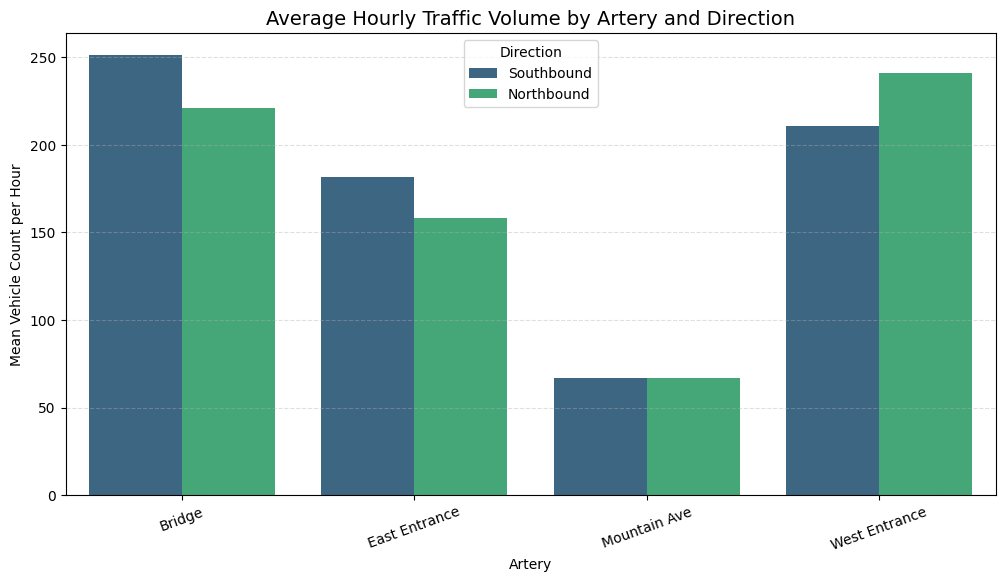

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df,
    x='artery',
    y='volume',
    hue='direction',
    estimator='mean',
    errorbar=None,
    palette='viridis'
)
plt.title("Average Hourly Traffic Volume by Artery and Direction", fontsize=14)
plt.xlabel("Artery")
plt.ylabel("Mean Vehicle Count per Hour")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Direction')
plt.show()

*Bridge and West Entrance record the highest average hourly volumes, confirming their role as Banff’s main access routes for visitors.*

## Distribution of Traffic Volume

**Boxplot of traffic volumes**
Boxplots highlight the distribution and variability of traffic volumes for each artery.

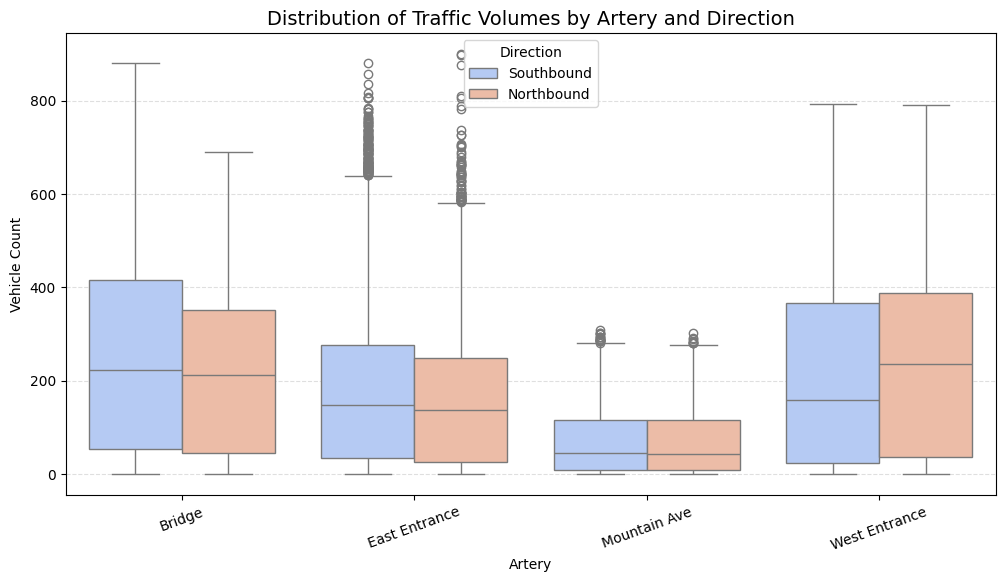

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df,
    x='artery',
    y='volume',
    hue='direction',
    palette='coolwarm'
)
plt.title("Distribution of Traffic Volumes by Artery and Direction", fontsize=14)
plt.xlabel("Artery")
plt.ylabel("Vehicle Count")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Direction')
plt.show()

*Bridge and West Entrance display wide variability and frequent high-volume hours, while Mountain Ave maintains a stable low-traffic profile.*

## Hourly Traffic Trends

**Hourly traffic trends per artery**
To observe daily traffic dynamics, we plot the average hourly traffic flow
for each artery and direction.
This helps identify rush hours and potential congestion times.

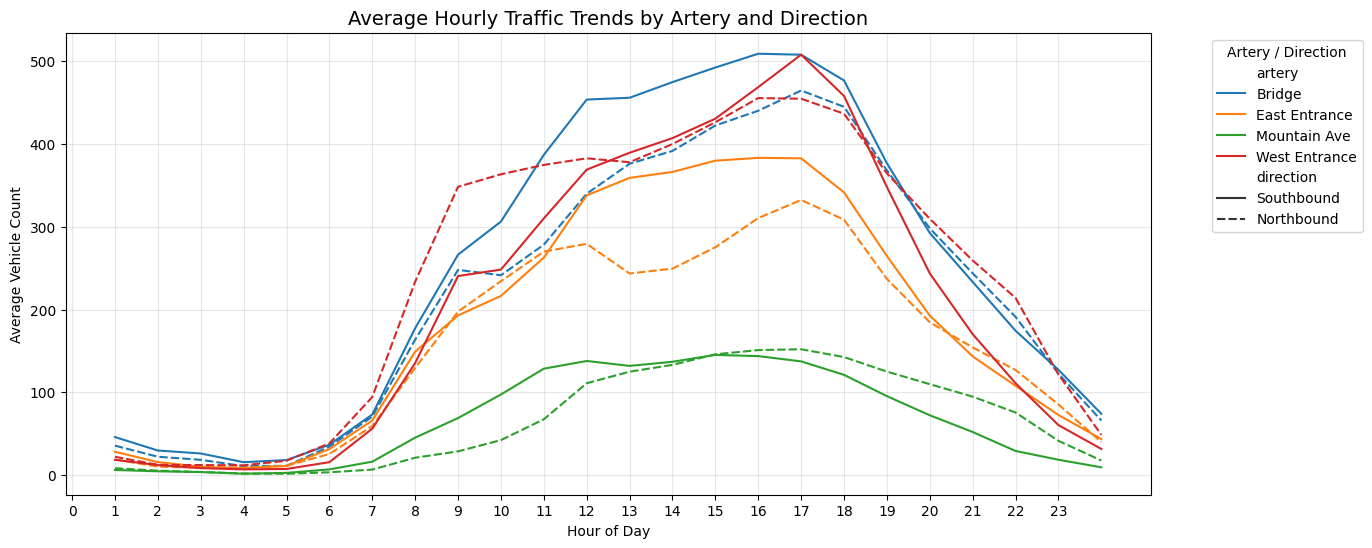

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=df,
    x='hour',
    y='volume',
    hue='artery',
    style='direction',
    estimator='mean',
    errorbar=None
)
plt.title("Average Hourly Traffic Trends by Artery and Direction", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicle Count")
plt.xticks(range(0,24))
plt.grid(alpha=0.3)
plt.legend(title='Artery / Direction', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

*All routes exhibit strong daytime peaks, especially Bridge and West Entrance,
while Mountain Ave maintains steady, low-volume activity.*

## Heatmap of Hourly Patterns

**Heatmap of hourly traffic volume by day and hour**
A heatmap provides a visual overview of traffic intensity throughout the day and across different dates.
It can reveal weekly cycles, peak hours, or consistent low-traffic periods.

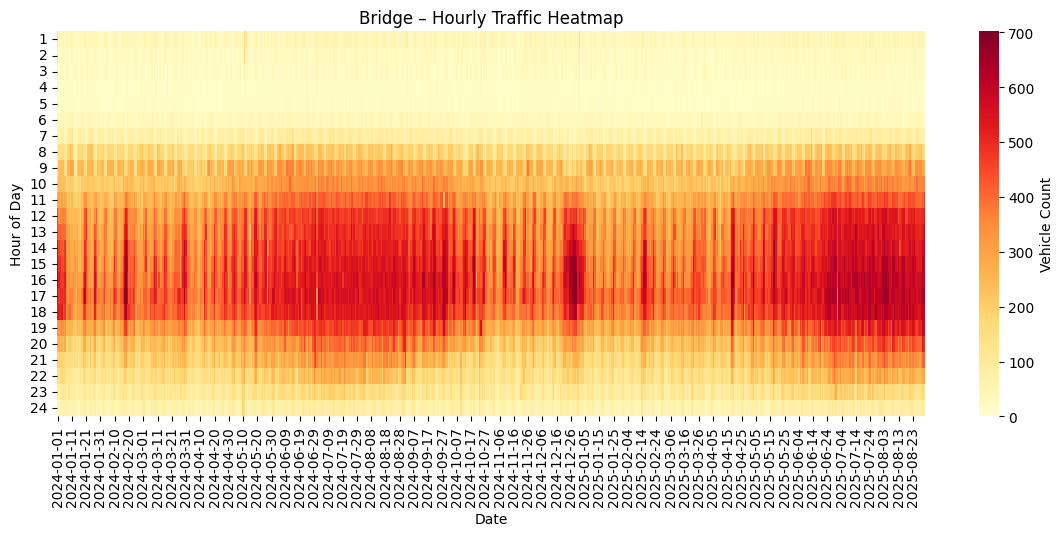

In [ ]:
# Compute average hourly traffic per date and hour
df_heat = df.groupby(['artery', 'date', 'hour'])['volume'].mean().reset_index()

# Example: plot for one artery (Bridge)
plt.figure(figsize=(14,5))
heat_data = df_heat[df_heat['artery'] == 'Bridge'].pivot(index='hour', columns='date', values='volume')
sns.heatmap(heat_data, cmap='YlOrRd', cbar_kws={'label': 'Vehicle Count'})
plt.title("Bridge – Hourly Traffic Heatmap")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()

*Daytime peaks (10 AM–5 PM) remain consistent throughout the year, with slightly higher intensities during summer months.*

The previous heatmap confirmed clear daily traffic cycles for the Bridge artery.
We now enhance the visualization for readability and create a small multiple comparison
between arteries to observe differences in traffic intensity across the city.

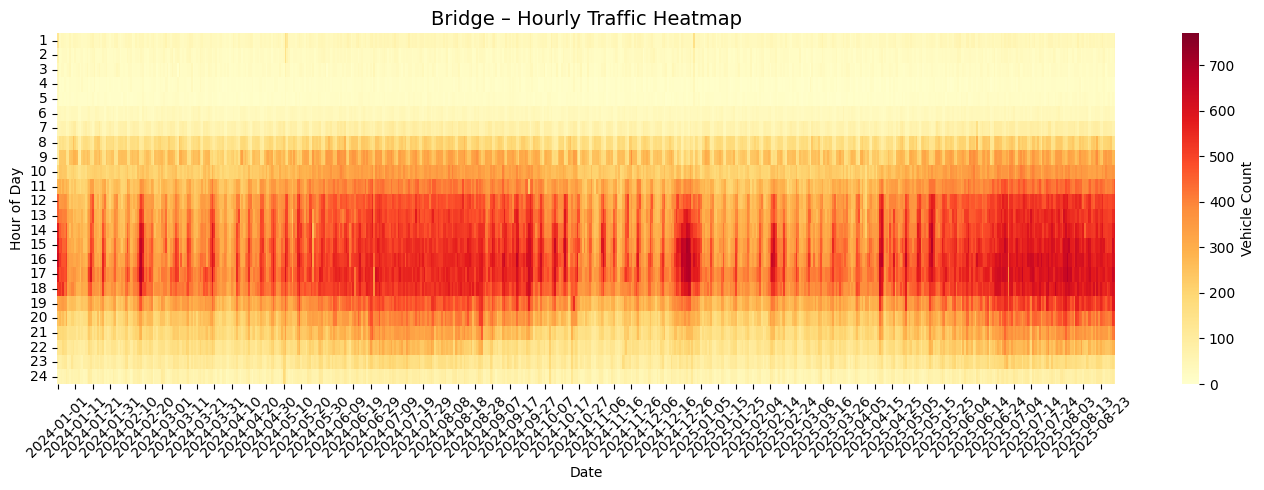

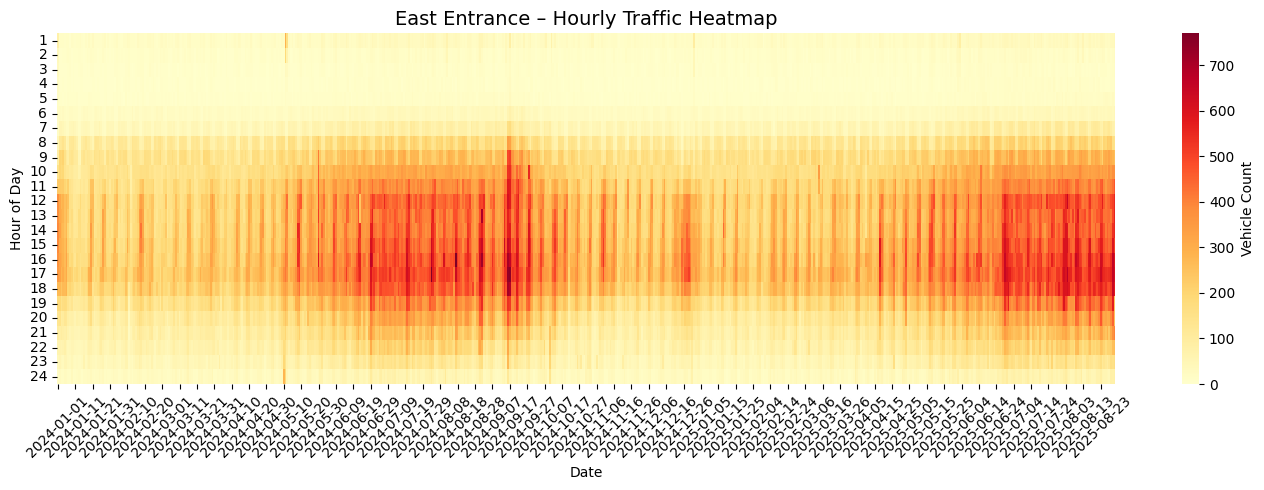

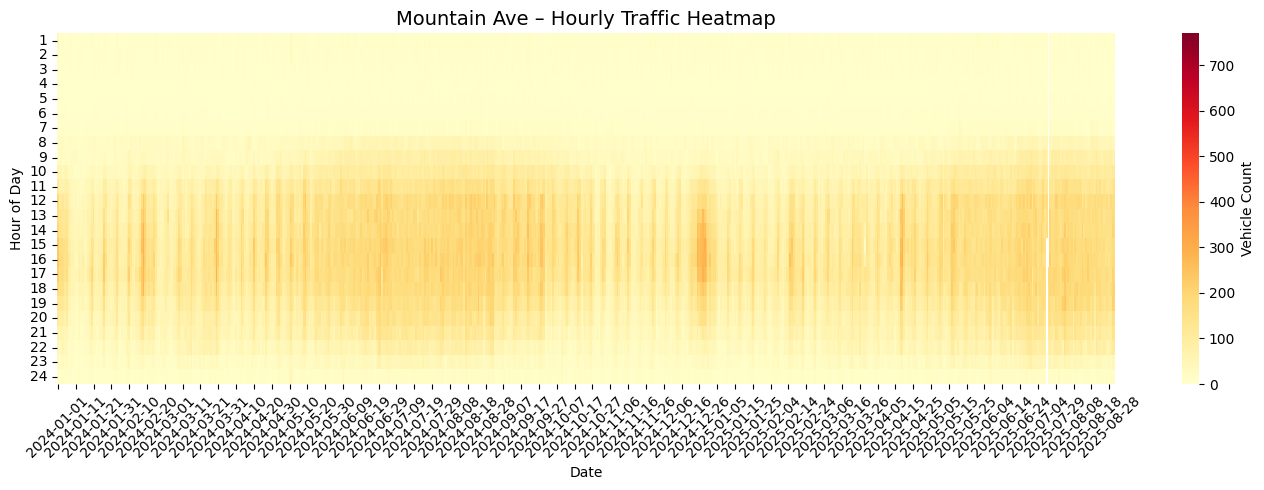

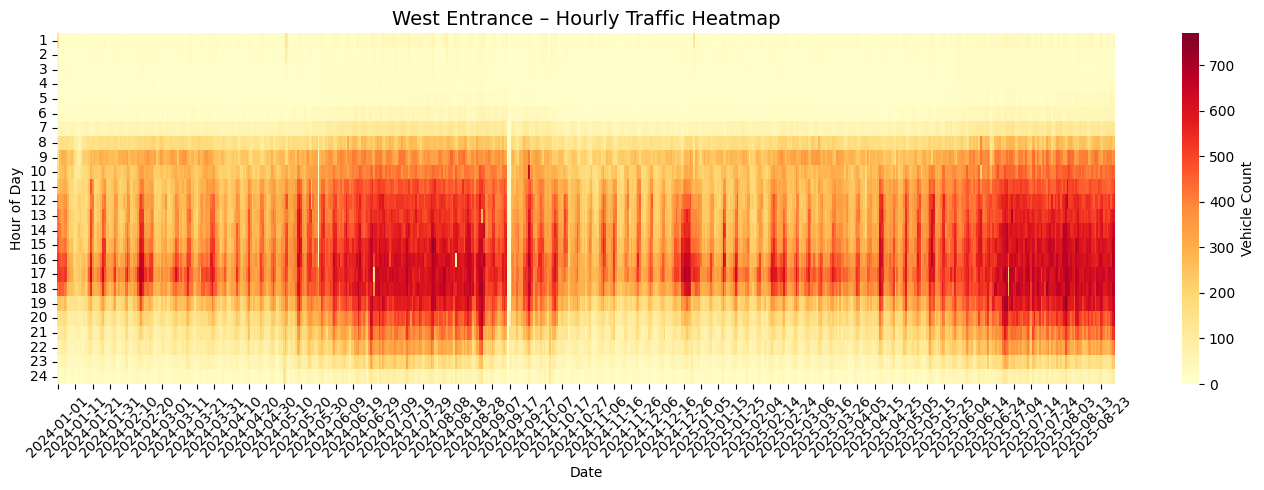

In [ ]:
import matplotlib.dates as mdates

# Function to plot heatmap for a given artery
def plot_heatmap(artery_name):
    heat_data = (
        df_heat[df_heat['artery'] == artery_name]
        .pivot(index='hour', columns='date', values='volume')
    )
    plt.figure(figsize=(14,5))
    sns.heatmap(
        heat_data,
        cmap='YlOrRd',
        cbar_kws={'label': 'Vehicle Count'},
        vmin=0,
        vmax=df_heat['volume'].max()
    )
    plt.title(f"{artery_name} – Hourly Traffic Heatmap", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Hour of Day")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for all main arteries
for artery in df['artery'].unique():
    plot_heatmap(artery)


## Correlation Analysis Between Arteries and Directions

Correlation helps determine how closely traffic flows across different arteries move together over time.
Strong positive correlations indicate similar traffic patterns (e.g., simultaneous congestion),

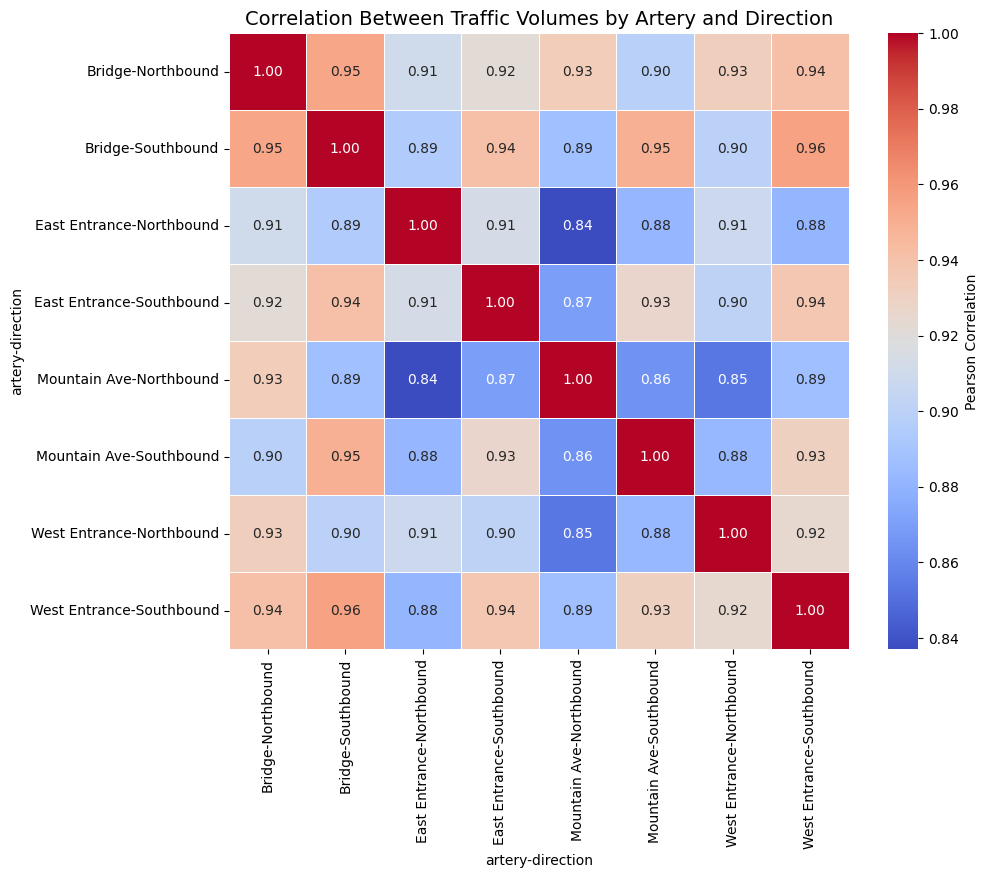

In [ ]:
# 1️ Pivot the data: one column per artery-direction
df_corr = df.pivot_table(
    index='datetime',
    columns=['artery', 'direction'],
    values='volume',
    aggfunc='mean'
)

# 2️ Compute the correlation matrix
corr_matrix = df_corr.corr(method='pearson')

# 3️ Visualize correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Pearson Correlation'}
)
plt.title("Correlation Between Traffic Volumes by Artery and Direction", fontsize=14)
plt.show()


*Strong positive correlations indicate unified traffic behavior across Banff’s main arteries, with Bridge and West Entrance showing the closest relationship.*

## Simplify Correlations by Artery

To focus on relationships between arteries instead of directions,
we compute the average hourly volume across both directions (Northbound and Southbound) for each artery.
Then, we build a simplified correlation matrix showing how total traffic in each artery correlates with the others.

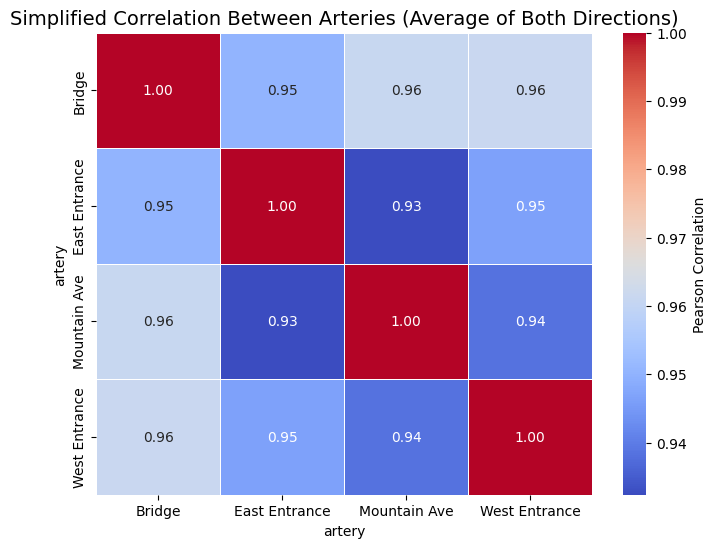

In [ ]:
# Compute mean volume across both directions
df_avg = df.groupby(['datetime', 'artery'])['volume'].mean().unstack()

# Compute correlation between arteries
corr_arteries = df_avg.corr(method='pearson')

# Plot simplified correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_arteries,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Pearson Correlation'}
)
plt.title("Simplified Correlation Between Arteries (Average of Both Directions)", fontsize=14)
plt.show()

*All arteries exhibit strong synchronization, with Bridge, Mountain Ave, and West Entrance showing the tightest relationships.*

## Annual Traffic Trend on the Bridge (Seasonality Analysis)

To identify seasonal patterns, we analyze the average daily and monthly traffic volumes on the Bridge artery.

This visualization helps reveal how vehicle flow evolves throughout the year,
highlighting tourism peaks (summer) and low-traffic periods (winter).

Both daily and monthly trends are computed by aggregating the hourly data.

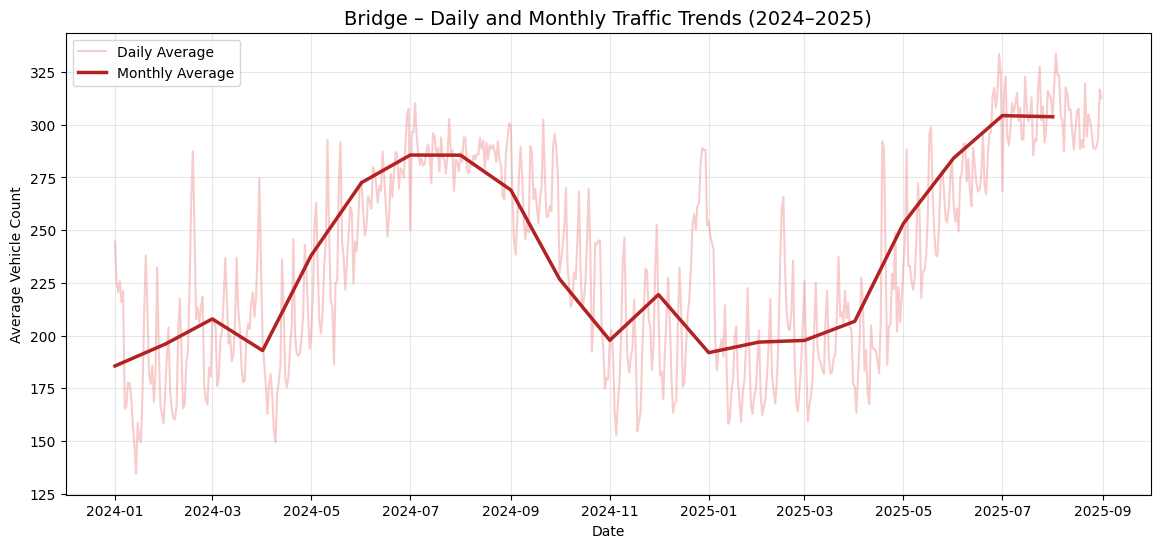

In [ ]:
# Filter only Bridge data
df_bridge = df[df['artery'] == 'Bridge'].copy()

# Convert date column to datetime if not already
df_bridge['date'] = pd.to_datetime(df_bridge['date'])

# Compute daily and monthly averages (averaging both directions)
daily_volume = (
    df_bridge.groupby('date')['volume']
    .mean()
    .reset_index()
)

monthly_volume = (
    df_bridge.groupby(df_bridge['date'].dt.to_period('M'))['volume']
    .mean()
    .reset_index()
)
monthly_volume['date'] = monthly_volume['date'].dt.to_timestamp()

# Plot both daily and monthly trends
plt.figure(figsize=(14,6))
plt.plot(daily_volume['date'], daily_volume['volume'], color='lightcoral', alpha=0.4, label='Daily Average')
plt.plot(monthly_volume['date'], monthly_volume['volume'], color='firebrick', linewidth=2.5, label='Monthly Average')
plt.title("Bridge – Daily and Monthly Traffic Trends (2024–2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Vehicle Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


*Bridge traffic shows a clear seasonal pattern with summer peaks and winter declines, mirroring Banff’s tourism-driven mobility cycle.*

**The annual trend clearly shows strong seasonality in vehicle flow across the Bridge:**

- Summer peaks (June–August) are evident in both years, with average counts reaching their highest levels — consistent with Banff’s peak tourist season.

- Winter lows (November–February) display a marked reduction in traffic volume, reflecting lower visitation and possible weather-related effects.

- Spring (April–May) and early autumn (September–October) act as transitional periods with moderate but steady traffic recovery or decline.

- The pattern repeats consistently across 2024 and 2025, confirming that Bridge traffic is strongly driven by seasonal tourism activity.

Overall, this confirms that the Bridge serves as the main pulse of Banff’s vehicular mobility, directly reflecting tourism intensity and seasonal visitation dynamics

## Seasonality Comparison Across Arteries (Monthly Trends)

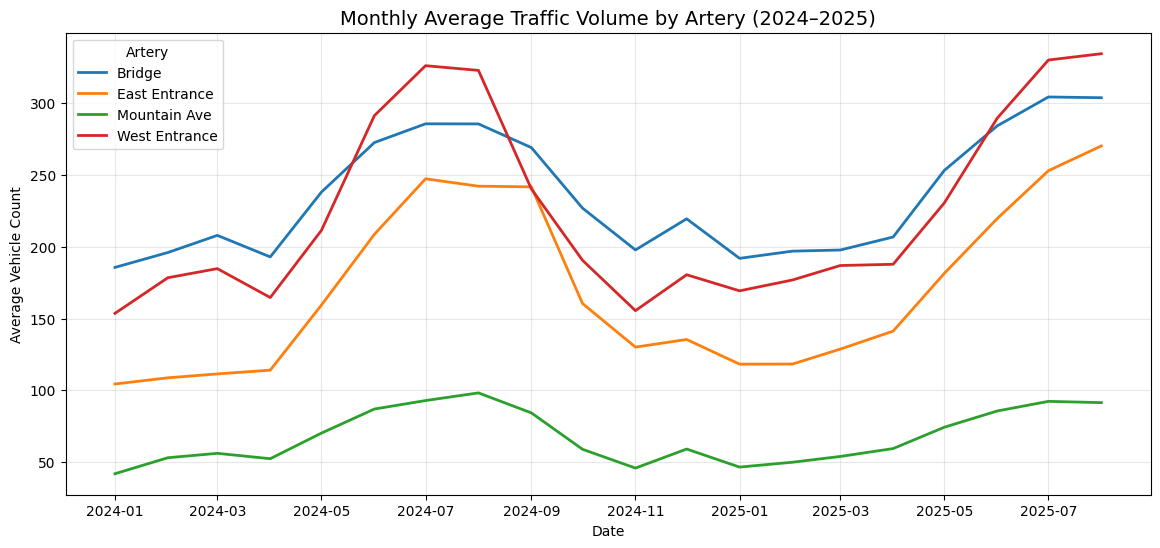

In [ ]:
# Compute monthly averages (averaging both directions)
df['date'] = pd.to_datetime(df['date'])
df_monthly = (
    df.groupby([df['date'].dt.to_period('M'), 'artery'])['volume']
    .mean()
    .reset_index()
)
df_monthly['date'] = df_monthly['date'].dt.to_timestamp()

# Plot monthly averages per artery
plt.figure(figsize=(14,6))
for artery in df_monthly['artery'].unique():
    subset = df_monthly[df_monthly['artery'] == artery]
    plt.plot(subset['date'], subset['volume'], linewidth=2, label=artery)

plt.title("Monthly Average Traffic Volume by Artery (2024–2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Vehicle Count")
plt.grid(alpha=0.3)
plt.legend(title="Artery")
plt.show()


*All arteries display consistent seasonality, with pronounced increases during summer months and significant drops in winter.*

# 5. Final Conclusions – Traffic Volume and Seasonality Analysis

The traffic analysis across Banff’s four main arteries — **Bridge, East Entrance, Mountain Ave, and West Entrance** — revealed clear, structured mobility patterns consistent with tourism-driven activity.

**Key Findings:**

- Bridge and West Entrance carry the highest traffic volumes, confirming their role as the city’s main access routes.

- Mountain Ave shows consistently low and stable flow, indicating local circulation.

- Traffic peaks between 10 AM and 5 PM, with minimal activity at night.

- All arteries display strong positive correlations (0.9–0.96), reflecting synchronized citywide flow patterns.

- A clear seasonal trend emerges: volumes rise sharply in summer (June–August) and drop significantly during winter (November–February).

**Conclusion:**

Traffic behavior in Banff is highly predictable, structured, and strongly linked to tourism cycles.

The Bridge serves as the central indicator of overall city mobility, making it a key reference point for forecasting and congestion planning.

This analysis provides the foundation for the next phase — integrating parking data with traffic volumes using datetime as the shared key to explore the relationship between vehicle flow and parking occupancy.



-----------------------------------------------------------------------------------



# 6. Create Expanded Dataset for Regression and Integration

**Expand traffic dataset for regression and integration** To prepare the data for modeling and integration with parking datasets,
we reshape the traffic data from long to wide format.
Each artery–direction pair becomes an individual column containing hourly traffic volume,
and datetime serves as the unique temporal key across the entire dataset.

In [ ]:
# Create a combined key for artery and direction
df['artery_direction'] = df['artery'].str.replace(' ', '') + '_' + df['direction']

# Pivot the dataset: datetime as index, each artery_direction as column
df_expanded = df.pivot_table(
    index='datetime',
    columns='artery_direction',
    values='volume',
    aggfunc='mean'
).reset_index()

# Sort by datetime
df_expanded = df_expanded.sort_values('datetime').reset_index(drop=True)

# Display result
print("✅ Expanded dataset shape:", df_expanded.shape)
df_expanded.head()


✅ Expanded dataset shape: (14616, 9)


artery_direction,datetime,Bridge_Northbound,Bridge_Southbound,EastEntrance_Northbound,EastEntrance_Southbound,MountainAve_Northbound,MountainAve_Southbound,WestEntrance_Northbound,WestEntrance_Southbound
0,2024-01-01 01:00:00,128.0,122.0,104.0,49.0,39.0,34.0,252.0,29.0
1,2024-01-01 02:00:00,73.0,65.0,39.0,29.0,22.0,15.0,47.0,27.0
2,2024-01-01 03:00:00,41.0,52.0,34.0,21.0,9.0,9.0,34.0,14.0
3,2024-01-01 04:00:00,31.0,42.0,18.0,21.0,4.0,3.0,21.0,15.0
4,2024-01-01 05:00:00,21.0,36.0,7.0,21.0,3.0,3.0,17.0,3.0


In [ ]:
print(df_expanded['datetime'].min(), "→", df_expanded['datetime'].max())
print("Number of hourly records:", df_expanded.shape[0])
print("Columns:", df_expanded.columns.tolist())

2024-01-01 01:00:00 → 2025-09-01 00:00:00
Number of hourly records: 14616
Columns: ['datetime', 'Bridge_Northbound', 'Bridge_Southbound', 'EastEntrance_Northbound', 'EastEntrance_Southbound', 'MountainAve_Northbound', 'MountainAve_Southbound', 'WestEntrance_Northbound', 'WestEntrance_Southbound']


Save Volume data as 'df_volume_expanded.csv'

In [ ]:
# Define file name and path
file_name = "df_volume_expanded.csv"

# Save the DataFrame to a CSV file
df_expanded.to_csv(file_name, index=False, encoding='utf-8')

# Confirm file creation
print(f"✅ DataFrame successfully saved as '{file_name}'")
print(f"Rows: {df_expanded.shape[0]:,} | Columns: {df_expanded.shape[1]}")

# Download the file directly to your computer
from google.colab import files
files.download(file_name)

✅ DataFrame successfully saved as 'df_volume_expanded.csv'
Rows: 14,616 | Columns: 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>